# IMPORTS & CONFIG

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import random
import math
import cv2
import gc

from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import KFold, StratifiedKFold

import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchmetrics.classification import MulticlassF1Score,MulticlassAccuracy
from sklearn.metrics import f1_score , accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from glob import glob


# 2. BASIC SETTINGS

In [2]:
class CFG:
    seed =  42
    n_splits  = 5
    train_bs = 16
    valid_bs = 32
    lr = 1e-4
    min_lr = 1e-6
    warmup_epochs = 2
    weight_decay = 5e-2
    img_size = 224
    num_workers = 2
    epochs = 10
    model_name = "vit_large_patch16_224"
    pretrained = True
    device = "cuda" if torch.cuda.is_available() else "cpu"


def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

# LOAD DATA

In [3]:
train_df = pd.read_csv("/kaggle/input/sheep-classification-dataset/Sheep Classification Images/train_labels.csv")
train_df["path"] = "/kaggle/input/sheep-classification-dataset/Sheep Classification Images/train/" + train_df["filename"]
train_df.drop("filename", axis=1, inplace=True)
train_df = train_df[["path","label"]]
train_df

,path,label
0,/kaggle/input/sheep-classification-dataset/She...,Naeimi
1,/kaggle/input/sheep-classification-dataset/She...,Goat
2,/kaggle/input/sheep-classification-dataset/She...,Roman
3,/kaggle/input/sheep-classification-dataset/She...,Roman
4,/kaggle/input/sheep-classification-dataset/She...,Naeimi
...,...,...
677,/kaggle/input/sheep-classification-dataset/She...,Naeimi
678,/kaggle/input/sheep-classification-dataset/She...,Goat
679,/kaggle/input/sheep-classification-dataset/She...,Naeimi
680,/kaggle/input/sheep-classification-dataset/She...,Naeimi


In [4]:
test_path = "/kaggle/input/sheep-classification-dataset/Sheep Classification Images/test/"
test_paths = []
for dirname, _, filenames in os.walk(test_path):
    test_paths.append(filenames)
len(test_paths[0])
test_df = pd.DataFrame({"path" : test_paths[0]})
test_df["image_path"] =  "/kaggle/input/sheep-classification-dataset/Sheep Classification Images/test/" + test_df["path"]
test_df.drop("path", axis =1, inplace=True)
test_df = test_df.rename({"image_path" :"path"})
test_df.head()

,image_path
0,/kaggle/input/sheep-classification-dataset/She...
1,/kaggle/input/sheep-classification-dataset/She...
2,/kaggle/input/sheep-classification-dataset/She...
3,/kaggle/input/sheep-classification-dataset/She...
4,/kaggle/input/sheep-classification-dataset/She...


In [5]:
unique_labels = train_df["label"].unique()
label_mapping = { label : idx for idx , label in enumerate(unique_labels)}
train_df["label_idx"] = train_df["label"].map(label_mapping)
train_df.head()

,path,label,label_idx
0,/kaggle/input/sheep-classification-dataset/She...,Naeimi,0
1,/kaggle/input/sheep-classification-dataset/She...,Goat,1
2,/kaggle/input/sheep-classification-dataset/She...,Roman,2
3,/kaggle/input/sheep-classification-dataset/She...,Roman,2
4,/kaggle/input/sheep-classification-dataset/She...,Naeimi,0


# KFOLD SPLIT

In [6]:
train_df["fold"] = -1
skf = StratifiedKFold(n_splits = CFG.n_splits, shuffle=True, random_state = CFG.seed)
for fold_number, (tr_idx, val_idx) in enumerate(skf.split(X=train_df,y=train_df["label"])):
    train_df.loc[val_idx,"fold"] = fold_number

print("Distribution of samples per class across folds:")
print(train_df.groupby(['fold','label']).size().unstack(fill_value=0))

print("\nTotal samples per fold:")
print(train_df.groupby("fold").size())

Distribution of samples per class across folds:
label  Barbari  Goat  Harri  Naeimi  Najdi  Roman  Sawakni
fold                                                      
0            7    22     13      51     14     14       16
1            7    22     12      51     15     14       16
2            7    21     12      51     14     15       16
3            7    21     12      51     14     15       16
4            7    21     13      51     14     14       16

Total samples per fold:
fold
0    137
1    137
2    136
3    136
4    136
dtype: int64


## DATASET AND TRANSFORMS

In [7]:
from torchvision.transforms import InterpolationMode

import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.RandomResizedCrop(size=(CFG.img_size, CFG.img_size), scale=(0.8,1.0),p=1.0),
    A.HorizontalFlip(p=0.5),
     A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.7),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.7),
    A.CoarseDropout(
        max_holes=8,
        max_height=int(CFG.img_size * 0.1),
        max_width=int(CFG.img_size * 0.1),
        min_holes=1,
        min_height=int(CFG.img_size * 0.05),
        min_width=int(CFG.img_size * 0.05),
        fill_value=0,
        p=0.5
    ),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Resize(height=CFG.img_size, width=CFG.img_size), # Use height and width here too
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_216/107488228.py:11: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [8]:
class Customdataset(Dataset):

    def __init__(self, df, mode ="train",transforms=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform =transforms
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,idx, return_raw=False):
        row = self.df.iloc[idx]
        image_path = row["path"]
        label_idx = row["label_idx"] if "label_idx" in row else None
        # image = Image.open(image_path).convert("RGB")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if return_raw:
            if self.mode != "test":
                return image , label_idx
            else:
                return image
                
        if self.transform:
            image = self.transform(image = image)["image"]

        if self.mode != "test":
            return image, label_idx
        else:
            return image
  

# classification model

In [9]:
import torch.nn as nn
import timm

def get_model(model_name : str, num_classes : int, pretrained : bool = True):
    model = timm.create_model(model_name, pretrained=pretrained)
    if hasattr(model,'head') and isinstance(model.head,nn.Linear):
        model.head = nn.Linear(model.head.in_features,num_classes)
    else:
        pass
    return model

# TRAIN AND VAL FUNCS

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation metric doesn't improve after a given patience.
    Also saves the best model's state_dict.
    """
    def __init__(self, patience=7, verbose=False, delta=0, mode='max', path='checkpoint.pth', trace_func=print):
        """
        Args:
            patience (int): How many epochs to wait after last time validation metric improved.
            verbose (bool): If True, prints a message for each validation metric improvement.
            delta (float): Minimum change in the monitored metric to qualify as an improvement.
            mode (str): 'min' for minimizing the metric (e.g., loss), 'max' for maximizing (e.g., F1-score).
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_corresponding_acc = None # To store accuracy when best_score was achieved
        self.early_stop = False
        self.delta = delta
        self.mode = mode
        self.path = path
        self.trace_func = trace_func

        if self.mode == 'max':
            self.best_score = -np.inf # Initialize for maximizing
        elif self.mode == 'min':
            self.best_score = np.inf # Initialize for minimizing
        else:
            raise ValueError("mode must be 'min' or 'max'")

    def __call__(self, val_metric, model, epoch, corresponding_acc=None): # Added corresponding_acc
        score = val_metric

        if self.best_score is None: # Should not happen with inf/-inf initialization
            self.best_score = score
            self.best_corresponding_acc = corresponding_acc
            self.save_checkpoint(model)
        elif (self.mode == 'max' and score < self.best_score + self.delta) or \
             (self.mode == 'min' and score > self.best_score - self.delta):
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if self.verbose:
                if self.mode == 'max':
                    self.trace_func(f'Validation metric improved ({self.best_score:.4f} --> {val_metric:.4f}). Saving model ...')
                else: # mode == 'min'
                    self.trace_func(f'Validation metric improved ({self.best_score:.4f} --> {val_metric:.4f}). Saving model ...')
            self.best_score = score
            self.best_corresponding_acc = corresponding_acc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        '''Saves model when validation metric improves.'''
        torch.save(model.state_dict(), self.path)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['label']), y=train_df['label'])
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(CFG.device)

In [12]:
def train_one_epoch(model , optimizer, dataloader, device, criterion, scheduler=None):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(dataloader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += loss.item() * imgs.size(0)

    epoch_loss =total_loss/len(dataloader.dataset)
    return epoch_loss

def valid_one_epoch(model, dataloader, device, criterion, num_classes):
    model.eval()
    total_loss = 0
    correct = 0
    total =0
    f1_metric = MulticlassF1Score(num_classes=num_classes, average= 'macro').to(device)
    accuracy_metric = MulticlassAccuracy(num_classes= num_classes, average = 'macro').to(device)

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device),labels.to(device)
            outputs = model(imgs)

            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim = 1)

            f1_metric.update(preds,labels)
            accuracy_metric.update(preds, labels)
    epoch_loss = total_loss/len(dataloader.dataset)
    epoch_f1 = f1_metric.compute()
    epoch_accuracy = accuracy_metric.compute()
    return epoch_loss,epoch_f1, epoch_accuracy
    

In [13]:
def run_training(fold):
    print(f"========== Fold: {fold} ==========")
    num_classes = len(label_mapping)

    # Split data
    train_data = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_data = train_df[train_df["fold"] == fold].reset_index(drop=True)

    # Datasets
    train_dataset = Customdataset(train_data, mode="train", transforms=train_transforms)
    valid_dataset = Customdataset(valid_data, mode="valid", transforms=valid_transforms)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True, num_workers=CFG.num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False, num_workers=CFG.num_workers)

    # Model
    model = get_model(model_name=CFG.model_name, num_classes=num_classes, pretrained=CFG.pretrained)
    model.to(CFG.device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor, label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr)

    total_steps = len(train_loader) * CFG.epochs
    warmup_steps = len(train_loader) * CFG.warmup_epochs

    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(CFG.min_lr / CFG.lr, 0.5 * (1 + math.cos(math.pi * progress)))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # --- Initialize Early Stopping ---
    early_stopping = EarlyStopping(
        patience=3, # As discussed, 5 seems like a good balance
        verbose=True,
        delta=0.0001,
        mode='max',
        path=f"{CFG.model_name}_fold_{fold}_best_f1.pth"
    )

    # For plotting (still track all epochs' data)
    train_losses = []
    valid_losses = []
    valid_f1s = []
    valid_accs = []

    for epoch in range(CFG.epochs):
        print(f"Fold {fold} | Epoch {epoch+1}/{CFG.epochs}")

        train_loss = train_one_epoch(model, optimizer, train_loader, CFG.device, criterion, scheduler=scheduler)
        valid_loss, valid_f1, valid_acc = valid_one_epoch(model, valid_loader, CFG.device, criterion, num_classes)

        print(f"  [Train Loss: {train_loss:.4f}]  [Valid Loss: {valid_loss:.4f}]  [Valid F1: {valid_f1:.4f}]  [Valid Acc: {valid_acc:.4f}]")

        # --- Call Early Stopping and Check for Stop Signal ---
        early_stopping(valid_f1, model, epoch + 1, corresponding_acc=valid_acc)

        # Track metrics for plotting (before potentially stopping)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_f1s.append(valid_f1)
        valid_accs.append(valid_acc)

        if early_stopping.early_stop:
            print(f"  --> Early stopping triggered at Epoch {epoch + 1}!")
            break

    print(f"\nFold {fold} Best F1-Score: {early_stopping.best_score:.4f}")
    print(f"Fold {fold} Corresponding Accuracy: {early_stopping.best_corresponding_acc:.4f}\n")

    # --- Load the best model weights found by EarlyStopping ---
    model.load_state_dict(torch.load(early_stopping.path))

    # --- Final Evaluation and Classification Report for the Best Model ---
    print("\n--- Final Evaluation on Validation Set (Best Model from Early Stopping) ---")
    model.eval() # Ensure model is in evaluation mode
    final_all_preds = []
    final_all_labels = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(CFG.device), labels.to(CFG.device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            final_all_preds.extend(preds.cpu().numpy())
            final_all_labels.extend(labels.cpu().numpy())

    # Get class names for the report
    # Assuming label_mapping is a dictionary like {'class_name_A': 0, 'class_name_B': 1, ...}
    # Create a mapping from ID to class name
    id_to_class_name = {v: k for k, v in label_mapping.items()}
    # Ensure target_names are sorted by ID to match sklearn's internal ordering
    target_names = [id_to_class_name[i] for i in sorted(id_to_class_name.keys())]

    # Generate and Print Classification Report
    report_dict = classification_report(final_all_labels, final_all_preds, target_names=target_names, output_dict=True)
    print(classification_report(final_all_labels, final_all_preds, target_names=target_names))

    # --- Plot Classification Report Metrics (Precision, Recall, F1-Score per Class) ---
    metrics_to_plot = ['precision', 'recall', 'f1-score']
    class_metrics_data = {}
    for class_name in target_names:
        if class_name in report_dict:
            class_metrics_data[class_name] = {metric: report_dict[class_name][metric] for metric in metrics_to_plot}

    classes = list(class_metrics_data.keys())
    precision_scores = [class_metrics_data[c]['precision'] for c in classes]
    recall_scores = [class_metrics_data[c]['recall'] for c in classes]
    f1_scores = [class_metrics_data[c]['f1-score'] for c in classes]

    x = np.arange(len(classes)) # label locations
    width = 0.25 # width of the bars

    fig, ax = plt.subplots(figsize=(14, 7)) # Adjusted figure size for better readability
    rects1 = ax.bar(x - width, precision_scores, width, label='Precision', color='skyblue')
    rects2 = ax.bar(x, recall_scores, width, label='Recall', color='lightcoral')
    rects3 = ax.bar(x + width, f1_scores, width, label='F1-Score', color='lightgreen')

    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Score')
    ax.set_title(f'Classification Report Metrics by Class (Fold {fold} - Best Model)')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha="right") # Rotate labels for readability
    ax.legend()
    ax.set_ylim(0, 1.05) # Scores are between 0 and 1

    fig.tight_layout()
    plt.savefig(f"fold_{fold}_classification_report_plot.png") # Save the plot
    plt.show()


    # Plotting training/validation curves (from previous code)
    epochs_trained = range(1, len(train_losses) + 1)

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_trained, train_losses, label='Train Loss')
    plt.plot(epochs_trained, valid_losses, label='Valid Loss')
    plt.title(f"Fold {fold} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs_trained, [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in valid_f1s], label='Valid F1', color='green')
    plt.title(f"Fold {fold} - Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_trained, [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in valid_accs], label='Valid Accuracy', color='orange')
    plt.title(f"Fold {fold} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"fold_{fold}_training_plot.png")
    plt.show()

    return early_stopping.best_score, early_stopping.best_corresponding_acc

========== Fold: 0 ==========
Fold 0 | Epoch 1/10


  [Train Loss: 1.3262]  [Valid Loss: 0.6598]  [Valid F1: 0.7019]  [Valid Acc: 0.7202]
Validation metric improved (-inf --> 0.7019). Saving model ...
Fold 0 | Epoch 2/10


  [Train Loss: 0.4898]  [Valid Loss: 0.5466]  [Valid F1: 0.7481]  [Valid Acc: 0.7720]
Validation metric improved (0.7019 --> 0.7481). Saving model ...
Fold 0 | Epoch 3/10


  [Train Loss: 0.5346]  [Valid Loss: 0.5798]  [Valid F1: 0.8680]  [Valid Acc: 0.8538]
Validation metric improved (0.7481 --> 0.8680). Saving model ...
Fold 0 | Epoch 4/10


  [Train Loss: 0.4261]  [Valid Loss: 0.5107]  [Valid F1: 0.8887]  [Valid Acc: 0.8729]
Validation metric improved (0.8680 --> 0.8887). Saving model ...
Fold 0 | Epoch 5/10


  [Train Loss: 0.4223]  [Valid Loss: 0.5356]  [Valid F1: 0.8803]  [Valid Acc: 0.8540]
EarlyStopping counter: 1 out of 3
Fold 0 | Epoch 6/10


  [Train Loss: 0.3738]  [Valid Loss: 0.4965]  [Valid F1: 0.9038]  [Valid Acc: 0.8920]
Validation metric improved (0.8887 --> 0.9038). Saving model ...
Fold 0 | Epoch 7/10


  [Train Loss: 0.3550]  [Valid Loss: 0.4853]  [Valid F1: 0.9057]  [Valid Acc: 0.8920]
Validation metric improved (0.9038 --> 0.9057). Saving model ...
Fold 0 | Epoch 8/10


  [Train Loss: 0.3499]  [Valid Loss: 0.4713]  [Valid F1: 0.8985]  [Valid Acc: 0.8818]
EarlyStopping counter: 1 out of 3
Fold 0 | Epoch 9/10


  [Train Loss: 0.3495]  [Valid Loss: 0.4705]  [Valid F1: 0.9097]  [Valid Acc: 0.8928]
Validation metric improved (0.9057 --> 0.9097). Saving model ...
Fold 0 | Epoch 10/10


  [Train Loss: 0.3486]  [Valid Loss: 0.4701]  [Valid F1: 0.9097]  [Valid Acc: 0.8928]
EarlyStopping counter: 1 out of 3

Fold 0 Best F1-Score: 0.9097
Fold 0 Corresponding Accuracy: 0.8928


--- Final Evaluation on Validation Set (Best Model from Early Stopping) ---
              precision    recall  f1-score   support

      Naeimi       0.91      0.98      0.94        51
        Goat       1.00      1.00      1.00        22
       Roman       0.79      0.79      0.79        14
       Harri       1.00      0.77      0.87        13
     Sawakni       1.00      1.00      1.00        16
     Barbari       0.83      0.71      0.77         7
       Najdi       1.00      1.00      1.00        14

    accuracy                           0.93       137
   macro avg       0.93      0.89      0.91       137
weighted avg       0.94      0.93      0.93       137



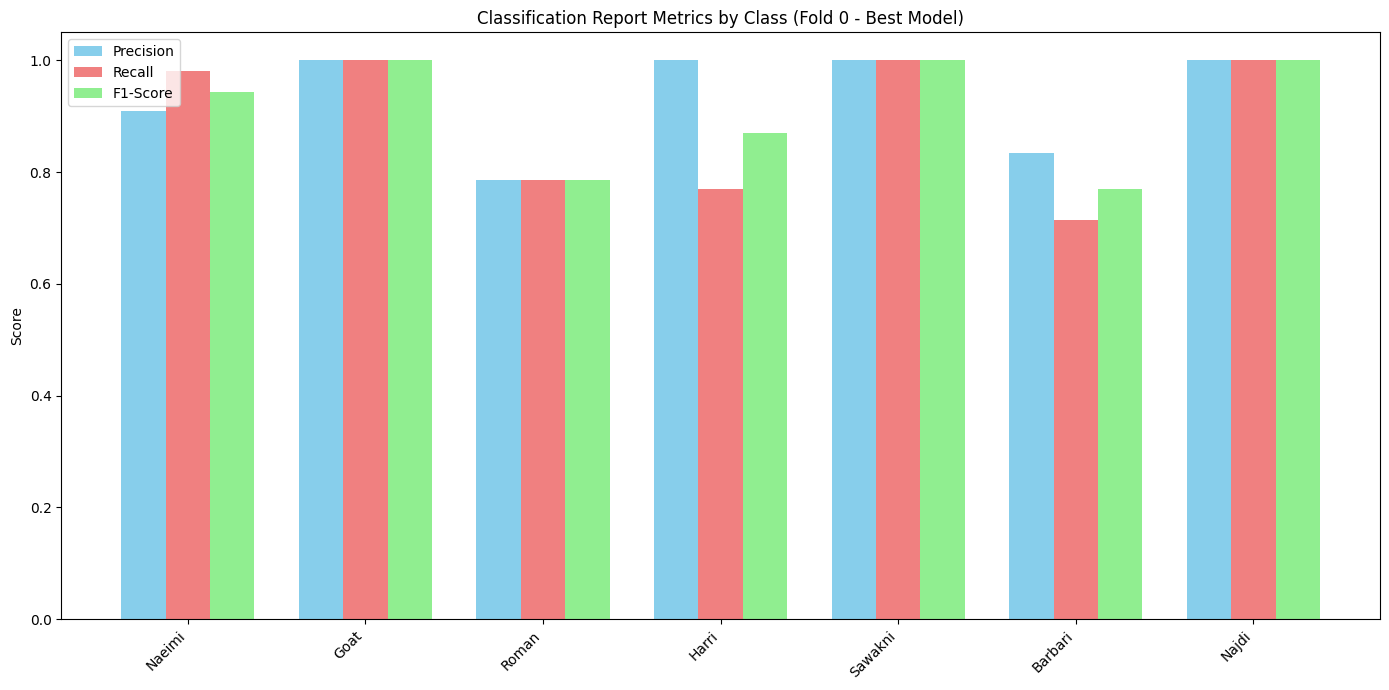

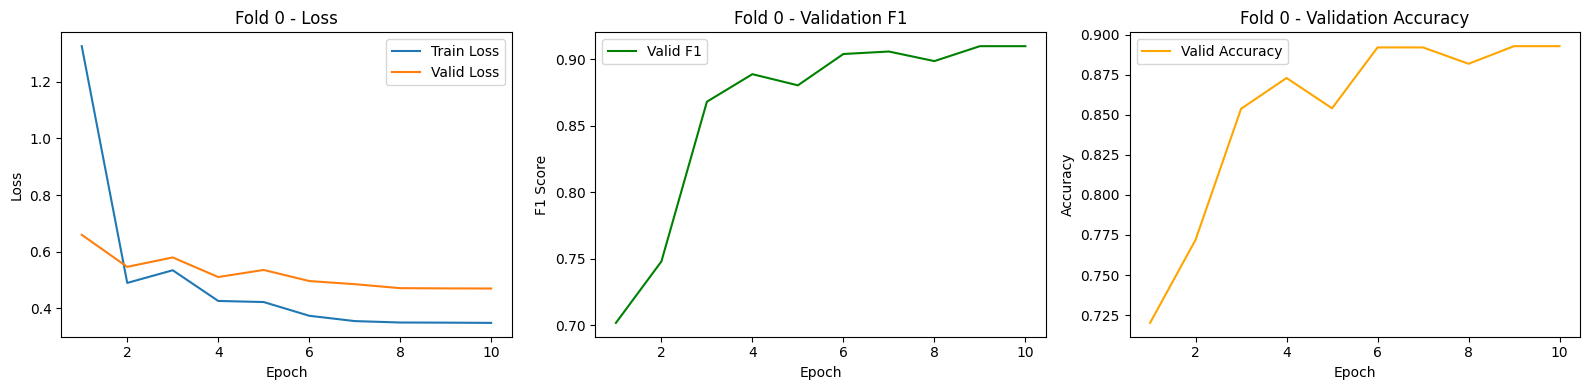

========== Fold: 1 ==========
Fold 1 | Epoch 1/10


  [Train Loss: 1.2013]  [Valid Loss: 0.5723]  [Valid F1: 0.8693]  [Valid Acc: 0.8410]
Validation metric improved (-inf --> 0.8693). Saving model ...
Fold 1 | Epoch 2/10


  [Train Loss: 0.5009]  [Valid Loss: 0.5248]  [Valid F1: 0.8534]  [Valid Acc: 0.8060]
EarlyStopping counter: 1 out of 3
Fold 1 | Epoch 3/10


  [Train Loss: 0.4506]  [Valid Loss: 0.5065]  [Valid F1: 0.8611]  [Valid Acc: 0.8439]
EarlyStopping counter: 2 out of 3
Fold 1 | Epoch 4/10


  [Train Loss: 0.3865]  [Valid Loss: 0.4416]  [Valid F1: 0.9078]  [Valid Acc: 0.8864]
Validation metric improved (0.8693 --> 0.9078). Saving model ...
Fold 1 | Epoch 5/10


  [Train Loss: 0.3776]  [Valid Loss: 0.4397]  [Valid F1: 0.9588]  [Valid Acc: 0.9456]
Validation metric improved (0.9078 --> 0.9588). Saving model ...
Fold 1 | Epoch 6/10


  [Train Loss: 0.3609]  [Valid Loss: 0.4306]  [Valid F1: 0.9427]  [Valid Acc: 0.9326]
EarlyStopping counter: 1 out of 3
Fold 1 | Epoch 7/10


  [Train Loss: 0.3552]  [Valid Loss: 0.4282]  [Valid F1: 0.9279]  [Valid Acc: 0.8983]
EarlyStopping counter: 2 out of 3
Fold 1 | Epoch 8/10


  [Train Loss: 0.3491]  [Valid Loss: 0.4282]  [Valid F1: 0.9279]  [Valid Acc: 0.8983]
EarlyStopping counter: 3 out of 3
  --> Early stopping triggered at Epoch 8!

Fold 1 Best F1-Score: 0.9588
Fold 1 Corresponding Accuracy: 0.9456


--- Final Evaluation on Validation Set (Best Model from Early Stopping) ---
              precision    recall  f1-score   support

      Naeimi       0.93      1.00      0.96        51
        Goat       1.00      1.00      1.00        22
       Roman       1.00      0.79      0.88        14
       Harri       0.91      0.83      0.87        12
     Sawakni       1.00      1.00      1.00        16
     Barbari       1.00      1.00      1.00         7
       Najdi       1.00      1.00      1.00        15

    accuracy                           0.96       137
   macro avg       0.98      0.95      0.96       137
weighted avg       0.96      0.96      0.96       137



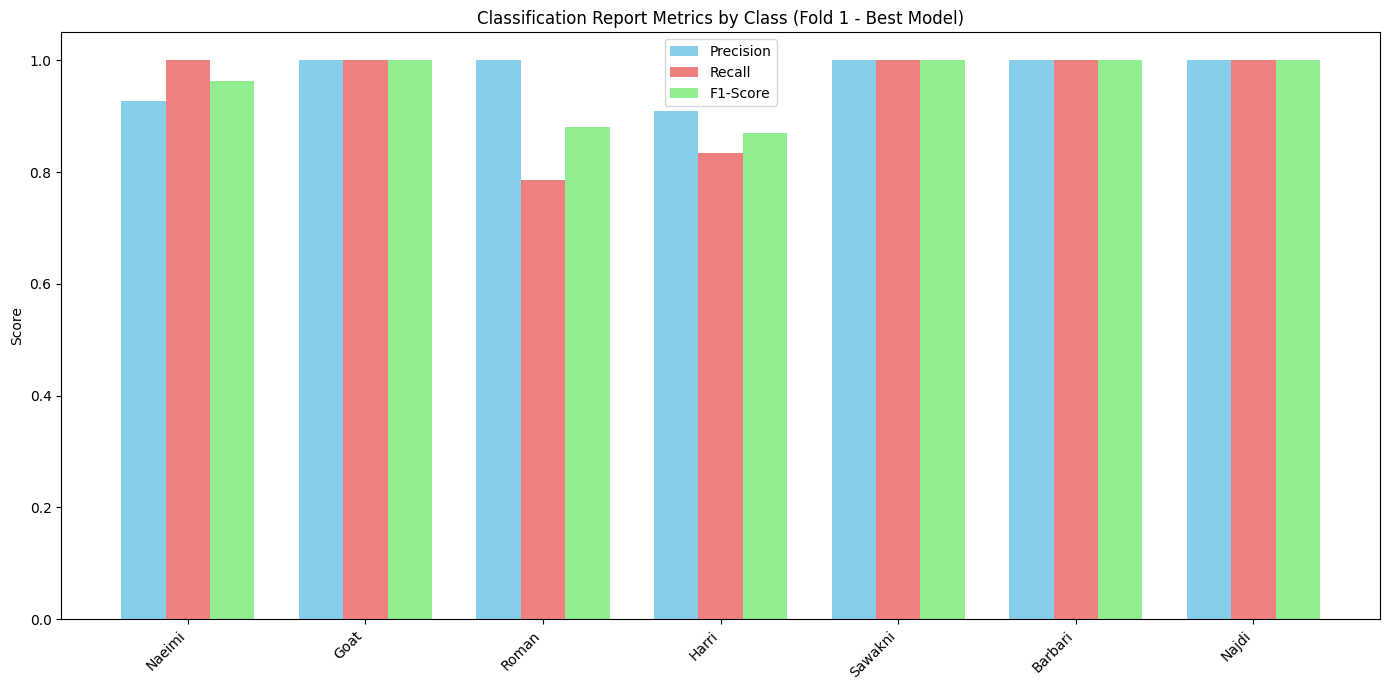

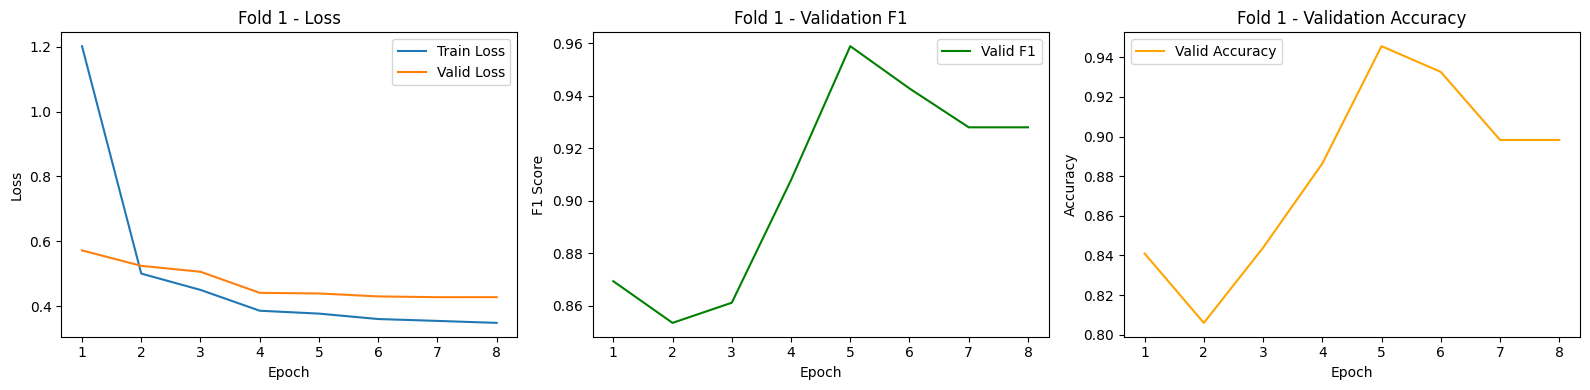

========== Fold: 2 ==========
Fold 2 | Epoch 1/10


  [Train Loss: 1.1532]  [Valid Loss: 0.6948]  [Valid F1: 0.7873]  [Valid Acc: 0.7677]
Validation metric improved (-inf --> 0.7873). Saving model ...
Fold 2 | Epoch 2/10


  [Train Loss: 0.4808]  [Valid Loss: 0.5648]  [Valid F1: 0.8962]  [Valid Acc: 0.8707]
Validation metric improved (0.7873 --> 0.8962). Saving model ...
Fold 2 | Epoch 3/10


  [Train Loss: 0.4835]  [Valid Loss: 0.5349]  [Valid F1: 0.8280]  [Valid Acc: 0.8006]
EarlyStopping counter: 1 out of 3
Fold 2 | Epoch 4/10


  [Train Loss: 0.4053]  [Valid Loss: 0.5077]  [Valid F1: 0.8657]  [Valid Acc: 0.8471]
EarlyStopping counter: 2 out of 3
Fold 2 | Epoch 5/10


  [Train Loss: 0.4056]  [Valid Loss: 0.5008]  [Valid F1: 0.8920]  [Valid Acc: 0.8815]
EarlyStopping counter: 3 out of 3
  --> Early stopping triggered at Epoch 5!

Fold 2 Best F1-Score: 0.8962
Fold 2 Corresponding Accuracy: 0.8707


--- Final Evaluation on Validation Set (Best Model from Early Stopping) ---
              precision    recall  f1-score   support

      Naeimi       0.88      1.00      0.94        51
        Goat       1.00      0.90      0.95        21
       Roman       1.00      0.67      0.80        15
       Harri       1.00      0.67      0.80        12
     Sawakni       0.76      1.00      0.86        16
     Barbari       1.00      0.86      0.92         7
       Najdi       1.00      1.00      1.00        14

    accuracy                           0.91       136
   macro avg       0.95      0.87      0.90       136
weighted avg       0.93      0.91      0.91       136



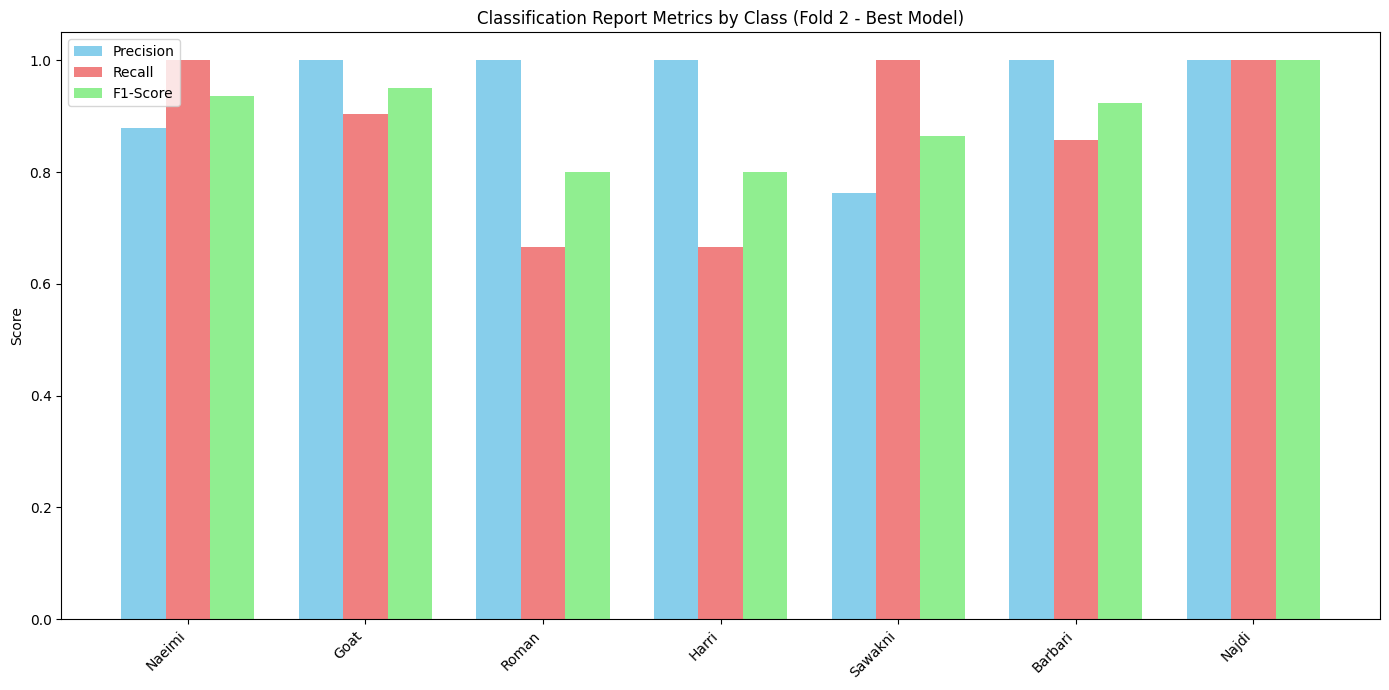

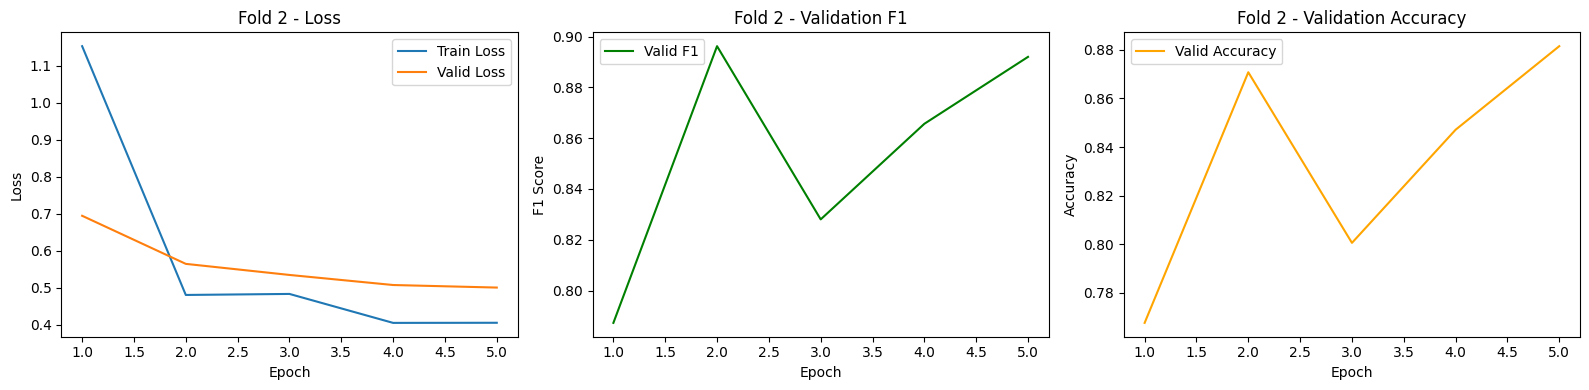

========== Fold: 3 ==========
Fold 3 | Epoch 1/10


  [Train Loss: 1.3428]  [Valid Loss: 0.7320]  [Valid F1: 0.7190]  [Valid Acc: 0.7190]
Validation metric improved (-inf --> 0.7190). Saving model ...
Fold 3 | Epoch 2/10


  [Train Loss: 0.5304]  [Valid Loss: 0.5572]  [Valid F1: 0.8351]  [Valid Acc: 0.8364]
Validation metric improved (0.7190 --> 0.8351). Saving model ...
Fold 3 | Epoch 3/10


  [Train Loss: 0.4481]  [Valid Loss: 0.4637]  [Valid F1: 0.9291]  [Valid Acc: 0.9223]
Validation metric improved (0.8351 --> 0.9291). Saving model ...
Fold 3 | Epoch 4/10


  [Train Loss: 0.4054]  [Valid Loss: 0.4729]  [Valid F1: 0.9392]  [Valid Acc: 0.9247]
Validation metric improved (0.9291 --> 0.9392). Saving model ...
Fold 3 | Epoch 5/10


  [Train Loss: 0.3747]  [Valid Loss: 0.4453]  [Valid F1: 0.9215]  [Valid Acc: 0.9071]
EarlyStopping counter: 1 out of 3
Fold 3 | Epoch 6/10


  [Train Loss: 0.3656]  [Valid Loss: 0.4585]  [Valid F1: 0.8936]  [Valid Acc: 0.8810]
EarlyStopping counter: 2 out of 3
Fold 3 | Epoch 7/10


  [Train Loss: 0.3542]  [Valid Loss: 0.4564]  [Valid F1: 0.9334]  [Valid Acc: 0.9219]
EarlyStopping counter: 3 out of 3
  --> Early stopping triggered at Epoch 7!

Fold 3 Best F1-Score: 0.9392
Fold 3 Corresponding Accuracy: 0.9247


--- Final Evaluation on Validation Set (Best Model from Early Stopping) ---
              precision    recall  f1-score   support

      Naeimi       0.89      1.00      0.94        51
        Goat       1.00      0.95      0.98        21
       Roman       1.00      0.67      0.80        15
       Harri       0.92      0.92      0.92        12
     Sawakni       0.94      0.94      0.94        16
     Barbari       1.00      1.00      1.00         7
       Najdi       1.00      1.00      1.00        14

    accuracy                           0.94       136
   macro avg       0.96      0.92      0.94       136
weighted avg       0.95      0.94      0.94       136



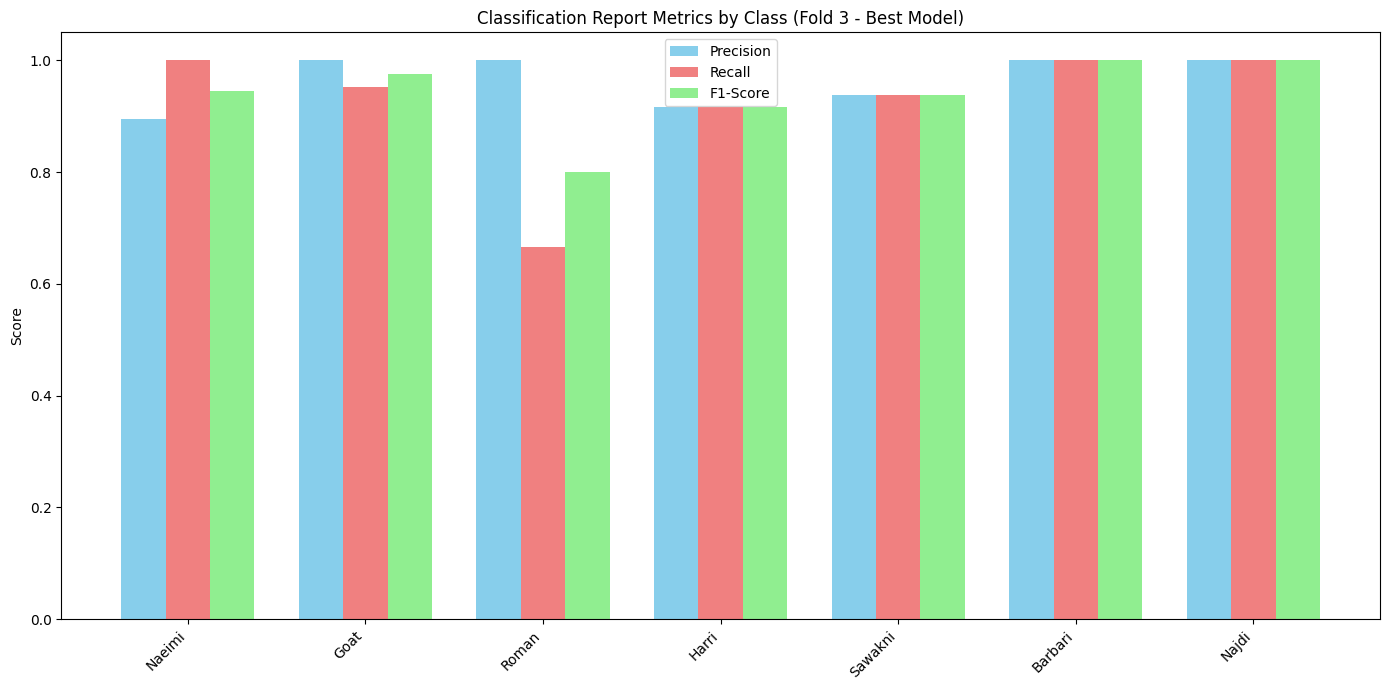

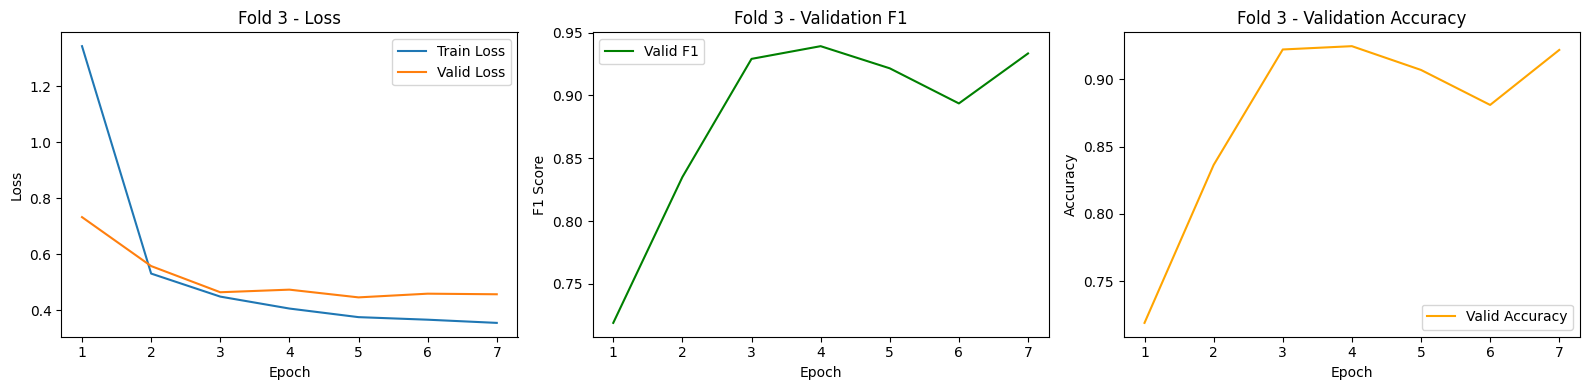

========== Fold: 4 ==========
Fold 4 | Epoch 1/10


  [Train Loss: 1.2361]  [Valid Loss: 0.4987]  [Valid F1: 0.9685]  [Valid Acc: 0.9577]
Validation metric improved (-inf --> 0.9685). Saving model ...
Fold 4 | Epoch 2/10


  [Train Loss: 0.6165]  [Valid Loss: 0.5254]  [Valid F1: 0.9142]  [Valid Acc: 0.9209]
EarlyStopping counter: 1 out of 3
Fold 4 | Epoch 3/10


  [Train Loss: 0.5033]  [Valid Loss: 0.5157]  [Valid F1: 0.9598]  [Valid Acc: 0.9574]
EarlyStopping counter: 2 out of 3
Fold 4 | Epoch 4/10


  [Train Loss: 0.4215]  [Valid Loss: 0.3933]  [Valid F1: 0.9494]  [Valid Acc: 0.9576]
EarlyStopping counter: 3 out of 3
  --> Early stopping triggered at Epoch 4!

Fold 4 Best F1-Score: 0.9685
Fold 4 Corresponding Accuracy: 0.9577


--- Final Evaluation on Validation Set (Best Model from Early Stopping) ---
              precision    recall  f1-score   support

      Naeimi       0.96      0.98      0.97        51
        Goat       0.91      1.00      0.95        21
       Roman       1.00      0.93      0.96        14
       Harri       1.00      1.00      1.00        13
     Sawakni       1.00      0.94      0.97        16
     Barbari       1.00      0.86      0.92         7
       Najdi       1.00      1.00      1.00        14

    accuracy                           0.97       136
   macro avg       0.98      0.96      0.97       136
weighted avg       0.97      0.97      0.97       136



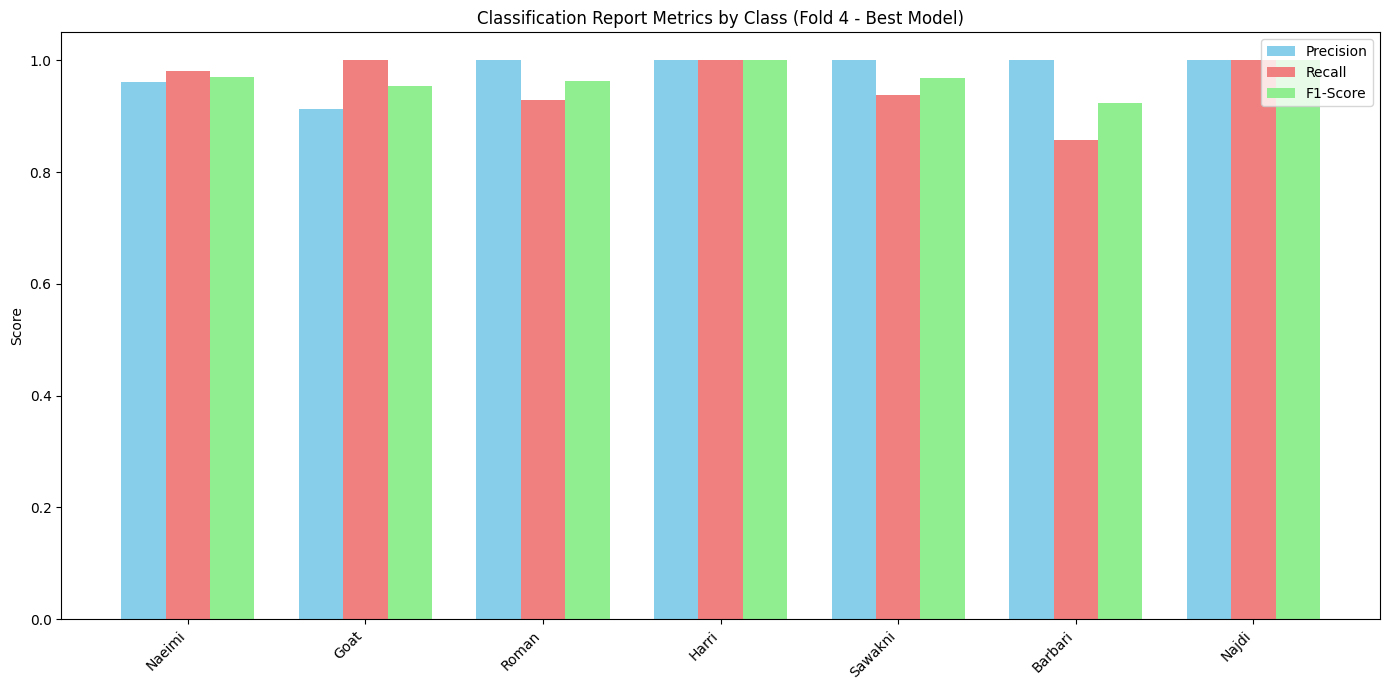

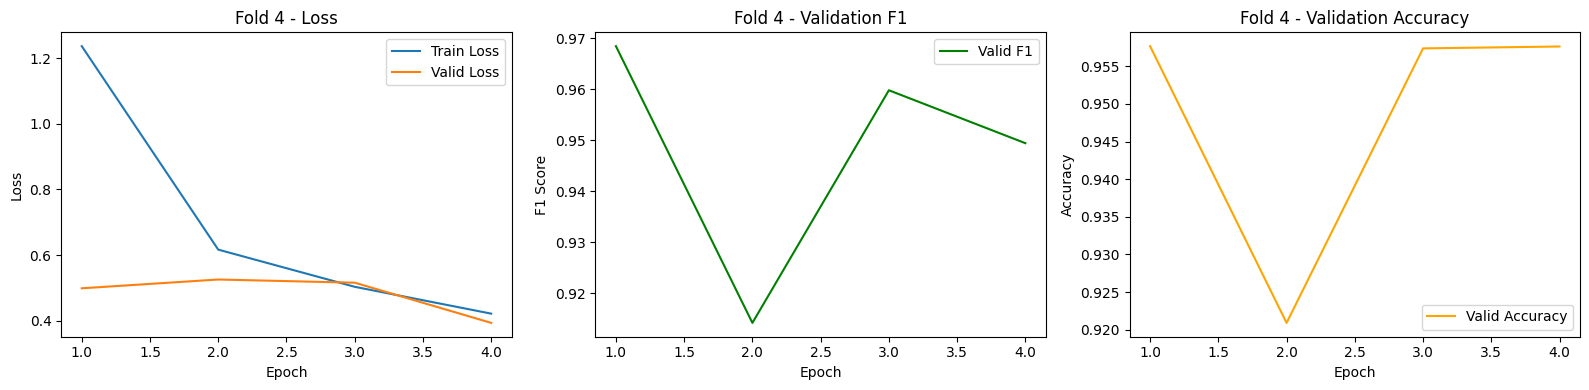


========== CV Summary ==========
Fold 0: Best F1 = 0.9097 | Accuracy = 0.8928
Fold 1: Best F1 = 0.9588 | Accuracy = 0.9456
Fold 2: Best F1 = 0.8962 | Accuracy = 0.8707
Fold 3: Best F1 = 0.9392 | Accuracy = 0.9247
Fold 4: Best F1 = 0.9685 | Accuracy = 0.9577

Estimated Public LB F1 Score: 0.9345
Estimated Public LB Accuracy: 0.9183


In [14]:
fold_f1_scores = []
fold_accuracies = []

for fold in range(CFG.n_splits):
    best_f1, best_acc = run_training(fold)  # Modify run_training to return these
    fold_f1_scores.append(best_f1)
    fold_accuracies.append(best_acc)

avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
avg_acc = sum(fold_accuracies) / len(fold_accuracies)

print("\n========== CV Summary ==========")
for i in range(CFG.n_splits):
    print(f"Fold {i}: Best F1 = {fold_f1_scores[i]:.4f} | Accuracy = {fold_accuracies[i]:.4f}")
print(f"\nEstimated Public LB F1 Score: {avg_f1:.4f}")
print(f"Estimated Public LB Accuracy: {avg_acc:.4f}")